In [1]:
## references: 
#1 : https://dmol.pub/ml/introduction.html

In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem.rdReducedGraphs import GetErGFingerprint
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



In [3]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
)
os.makedirs('./data', exist_ok=True)
soldata.to_csv('./data/curated-solubility-dataset.csv')
print(soldata.shape)

soldata.head(5)

(9982, 26)


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


vinyl 2-ethylhexanoate
CCCCC(CC)C(=O)OC=C
solubility: -4.1519109764


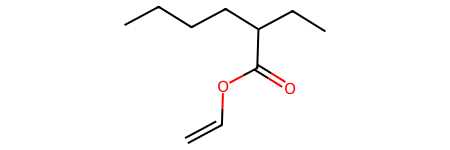

In [4]:
i = 100

mol = rdkit.Chem.MolFromInchi(soldata.InChI[i])
print(soldata["Name"][i])
print(soldata["SMILES"][i])
print(f"solubility: {soldata['Solubility'][i]}")
mol

In [5]:
mw = rdkit.Chem.Descriptors.MolWt(mol)
print(f"Molecular weight: {mw}")

Molecular weight: 170.25199999999998


In [6]:

def calculate_fp(mol_list, method='ecfp4', n_bits=2048):
    fp_list = []
    # mol = Chem molecule object
    # Function to calculate molecular fingerprints given the number of bits and the method
    for mol in tqdm(mol_list):
        if method == 'maccs':
            fp = Chem.MACCSkeys.GenMACCSKeys(mol)
        if method == 'ecfp4':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits, useFeatures=False)
        if method == 'ecfp6':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits, useFeatures=False)
        if method == 'torsion':
            fp = AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
        if method == 'rdk5':
            fp = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=1024, nBitsPerHash=2)
        if method == 'hashtopol':
            fp = AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
        if method == 'layer':
            fp = AllChem.LayeredFingerprint(mol)
        if method == 'pattern':
            fp = AllChem.PatternFingerprint(mol)
        if method == 'ErG':
            fp = GetErGFingerprint(mol)
        fp_list.append(np.array(fp))
    
    fp_arr = np.array(fp_list)

    return fp_arr

In [7]:
def RDkit_descriptors_2D(mol_list, desc_list):
    # simple_list = ['TPSA']
    calculator = MolecularDescriptorCalculator(desc_list)
    des_list = []
    for mol in tqdm(mol_list):
        des = np.array(calculator.CalcDescriptors(mol))
        des_list.append(des)
    des_arr = np.array(des_list)
    des_arr[des_arr == np.inf] = np.nan
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    des_arr = imp.fit_transform(des_arr)
    return des_arr

In [8]:
sol_smi_target = soldata[["SMILES", "Solubility"]].copy()
sol_smi_target

,SMILES,Solubility
0,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,O=C1Nc2cccc3cccc1c23,-3.254767
2,Clc1ccc(C=O)cc1,-2.177078
3,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
...,...,...
9977,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
9978,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
9979,c1(cc(ccc1C(C)C)C)O,-2.190000
9980,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000


In [9]:
len_data = len(sol_smi_target)
idx_rand = np.random.permutation(len_data)
n_train = int(0.8 * len(sol_smi_target))

In [10]:
print(idx_rand[:n_train])

[2653 3427  900 ... 3982 2061 4750]


In [11]:
train_data = sol_smi_target.iloc[idx_rand[:n_train]]
test_data = sol_smi_target.iloc[idx_rand[n_train:]]

In [12]:
print(train_data.shape, test_data.shape)

(7985, 2) (1997, 2)


In [13]:
train_smi_list = train_data.SMILES.values
test_smi_list = test_data.SMILES.values

In [14]:
train_mol_list = [Chem.MolFromSmiles(smi) for smi in train_smi_list]
test_mol_list = [Chem.MolFromSmiles(smi) for smi in test_smi_list]

[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not removing hydrogen atom without neighbors
[15:09:11] WARNING: not r

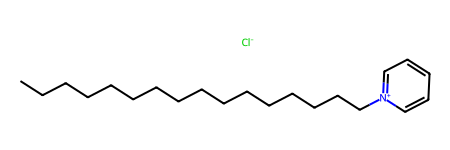

In [15]:
train_mol_list[0]

In [16]:
desc_list = [desc[0] for desc in Descriptors.descList]


In [17]:
# !rm -rf ./dataset

In [18]:
os.makedirs('./dataset', exist_ok=True)
if os.path.isfile('./dataset/train_rddesc_arr.npy'):
    train_rddesc_arr = np.load('./dataset/train_rddesc_arr.npy')
    test_rddesc_arr = np.load('./dataset/test_rddesc_arr.npy')

else:
    train_rddesc_arr = RDkit_descriptors_2D(train_mol_list, desc_list)
    test_rddesc_arr = RDkit_descriptors_2D(test_mol_list, desc_list)
    np.save('./dataset/train_rddesc_arr.npy', train_rddesc_arr)
    np.save('./dataset/test_rddesc_arr.npy', test_rddesc_arr)

  0%|          | 39/7985 [00:00<00:44, 178.26it/s][15:09:12] WARNING: not removing hydrogen atom without neighbors
[15:09:12] WARNING: not removing hydrogen atom without neighbors
  5%|▍         | 386/7985 [00:01<00:36, 210.02it/s][15:09:14] WARNING: not removing hydrogen atom without neighbors
[15:09:14] WARNING: not removing hydrogen atom without neighbors
  9%|▉         | 733/7985 [00:03<00:36, 196.32it/s][15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
[15:09:15] WARNING: not removing hydrogen atom without neighbors
 12

In [19]:
print(train_rddesc_arr.shape, test_rddesc_arr.shape)

(7985, 208) (1997, 208)


In [20]:
train_rddesc_arr[:, 0]

array([ 2.29217327,  8.62962963, 12.12553965, ..., 11.97305556,
        9.72652778,  5.0030135 ])

(array([116.,   0.,   0.,   1.,   7.,  13., 262.,  27.,  22.,  63.,  71.,
         68.,  83.,  69., 161., 206., 207., 312.,  27.,  11.,  18.,  13.,
         35., 111., 227., 224., 216., 205., 334., 646., 612., 610., 517.,
        559., 589., 501., 335., 169., 134.,  88.,  34.,  27.,  18.,  10.,
          6.,   0.,   0.,   0.,  12.,   9.]),
 array([ 0.        ,  0.34885306,  0.69770613,  1.04655919,  1.39541226,
         1.74426532,  2.09311839,  2.44197145,  2.79082452,  3.13967758,
         3.48853065,  3.83738371,  4.18623677,  4.53508984,  4.8839429 ,
         5.23279597,  5.58164903,  5.9305021 ,  6.27935516,  6.62820823,
         6.97706129,  7.32591436,  7.67476742,  8.02362048,  8.37247355,
         8.72132661,  9.07017968,  9.41903274,  9.76788581, 10.11673887,
        10.46559194, 10.814445  , 11.16329806, 11.51215113, 11.86100419,
        12.20985726, 12.55871032, 12.90756339, 13.25641645, 13.60526952,
        13.95412258, 14.30297565, 14.65182871, 15.00068177, 15.34953484,
 

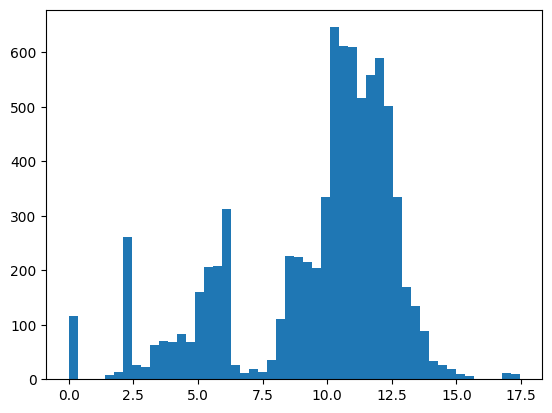

In [21]:
plt.hist(train_rddesc_arr[:, 0], bins=50)

In [22]:
## feature scaling
scaler = StandardScaler()
scale_fit = scaler.fit(train_rddesc_arr)
tr_scaled = scaler.transform(train_rddesc_arr)
te_scaled = scaler.transform(test_rddesc_arr)


/home/seoin-ub/miniconda3/envs/cheml/lib/python3.8/site-packages/sklearn/utils/extmath.py:1066: RuntimeWarning: overflow encountered in square
  temp **= 2


In [23]:
tr_scaled[:, 0]

array([-2.3138493 , -0.31459957,  0.78823992, ...,  0.74013643,
        0.0314341 , -1.45867235])

(array([116.,   0.,   0.,   1.,   7.,  13., 262.,  27.,  22.,  63.,  71.,
         68.,  83.,  69., 161., 206., 207., 312.,  27.,  11.,  18.,  13.,
         35., 111., 227., 224., 216., 205., 334., 646., 612., 610., 517.,
        559., 589., 501., 335., 169., 134.,  88.,  34.,  27.,  18.,  10.,
          6.,   0.,   0.,   0.,  12.,   9.]),
 array([-3.03695121, -2.92690005, -2.8168489 , -2.70679774, -2.59674658,
        -2.48669543, -2.37664427, -2.26659312, -2.15654196, -2.04649081,
        -1.93643965, -1.8263885 , -1.71633734, -1.60628619, -1.49623503,
        -1.38618388, -1.27613272, -1.16608157, -1.05603041, -0.94597926,
        -0.8359281 , -0.72587695, -0.61582579, -0.50577464, -0.39572348,
        -0.28567232, -0.17562117, -0.06557001,  0.04448114,  0.1545323 ,
         0.26458345,  0.37463461,  0.48468576,  0.59473692,  0.70478807,
         0.81483923,  0.92489038,  1.03494154,  1.14499269,  1.25504385,
         1.365095  ,  1.47514616,  1.58519731,  1.69524847,  1.80529962,
 

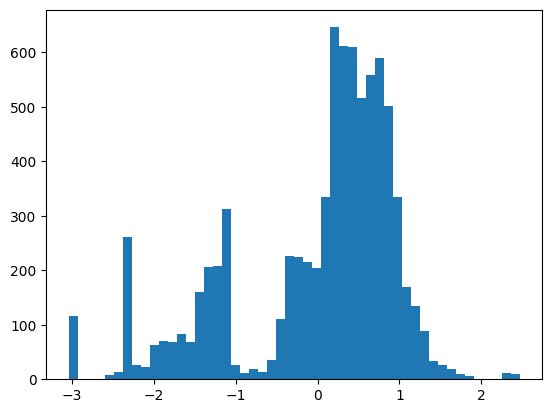

In [24]:
plt.hist(tr_scaled[:, 0], bins=50)

In [25]:
def fill_med(df):
    df = df.replace('na', np.nan) # alvadesc 결과에는 결측치가 문자열 'na'로 저장이 된다. np.nan 즉 null 값으로 변경
    df = df.astype('float32')     # 문자열타입으로 저장된 숫자를 실수타입으로 벼환
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median()) # 결측치를 칼럼의 median으로 채움
    df = df.dropna(axis=1)
    return df

In [26]:
df_tr_scaled = pd.DataFrame(tr_scaled, columns=desc_list)
df_te_scaled = pd.DataFrame(te_scaled, columns=desc_list)
df_tr_y = pd.DataFrame(train_data.Solubility.values, columns=["Solubility"])
df_te_y = pd.DataFrame(test_data.Solubility.values, columns=["Solubility"])

df_tr_tot = pd.concat([df_tr_scaled, df_tr_y], axis=1)
df_te_tot = pd.concat([df_te_scaled, df_te_y], axis=1)

df_tr_tot = fill_med(df_tr_tot)
df_te_tot = fill_med(df_te_tot)

/home/seoin-ub/miniconda3/envs/cheml/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/home/seoin-ub/miniconda3/envs/cheml/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [27]:
tr_scaled = df_tr_tot.iloc[:, :-1].values
te_scaled = df_te_tot.iloc[:, :-1].values


In [28]:
clf_lr = LinearRegression()
clf_svr = SVR()
clf_rf = RandomForestRegressor()

In [29]:
%time clf_lr.fit(tr_scaled, train_data.Solubility)
%time clf_svr.fit(tr_scaled, train_data.Solubility)
%time clf_rf.fit(tr_scaled, train_data.Solubility)

CPU times: user 89.5 ms, sys: 130 ms, total: 219 ms
Wall time: 35 ms
CPU times: user 3.19 s, sys: 596 ms, total: 3.78 s
Wall time: 3.04 s
CPU times: user 30.5 s, sys: 5.62 ms, total: 30.5 s
Wall time: 30.5 s


RandomForestRegressor()